### Lending Club - Part 5 - Project Goal 3.

Project Goals:
1. At loan origination: is my model able to predict if a customer will fully pay off their debt or will they incur a charge off
2. Multiclassification exercise: the objective of the second part is to get experience with multiclassification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

In [2]:
df = pd.read_csv('./lendingclub_processed.csv')

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_high,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,3600.0,3600.0,36,13.99,123.03,55000.0,Fully Paid,5.91,0.0,679.0,...,0,0,0,0,0,0,0,0,0,0
1,24700.0,24700.0,36,11.99,820.28,65000.0,Fully Paid,16.06,1.0,719.0,...,1,0,0,0,0,0,0,0,0,0
2,20000.0,20000.0,60,10.78,432.66,63000.0,Fully Paid,10.78,0.0,699.0,...,0,0,0,0,0,0,0,0,0,0
3,35000.0,35000.0,60,14.85,829.90,110000.0,Current,17.06,0.0,789.0,...,0,0,0,0,0,0,0,0,0,0
4,10400.0,10400.0,60,22.45,289.91,104433.0,Fully Paid,25.37,1.0,699.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off'], dtype=object)

In [6]:
df['loan_status'] = df['loan_status'].map({'Fully Paid': 2, 'Current': 1, 'Charged Off': 0})

Train, Validation, Test split

In [7]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [10]:
len(X_train)/len(df)

0.6999996846180567

In [11]:
len(X_val)/len(df)

0.15000015769097166

In [12]:
len(X_test)/len(df)

0.15000015769097166

## Modelling and validation

In this section, I will run multiple different classifers while using a gridsearch for hyperparameter tunning.

In [1]:
# model_results = []

In [2]:
# model_results_df = pd.DataFrame(data=model_results, 
#                                 columns=['model', 'f1_score_0', 'f1_score_1', 'accuracy', 'macro_avg', 'weighted_avg'])

In [3]:
# model_results_df

In [4]:
# grid = joblib.load('knn.pkl')
# preds = grid.predict(X_val)
# results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
# f1 = ['knn']
# for i in np.array(results.loc['f1-score']):
#     f1.append(i)
# model_results.append(f1)

## Logistic Regression 

In [13]:
model = LogisticRegression()

In [14]:
param_grid = {'clf__penalty': ['l1'],
             'clf__C': [1],
             'clf__solver': ['saga'],
             'clf__max_iter': [1000],
             'clf__multi_class' : ['ovr', 'multinomial'],
             'clf__n_jobs' : [-1]}

In [15]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [16]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=6, verbose=0)

In [17]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

C:\Users\kaile_000\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(
C:\Users\kaile_000\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


7:33:44.018994


              precision    recall  f1-score   support

           0       0.85      0.75      0.80     40403
           1       0.92      0.83      0.87    131132
           2       0.88      0.98      0.92    161395

    accuracy                           0.89    332930
   macro avg       0.88      0.85      0.87    332930
weighted avg       0.89      0.89      0.89    332930



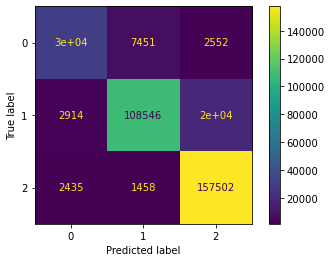

In [18]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [20]:
joblib.dump(grid, 'logistic_regression_final.pkl')
joblib.dump(grid.best_params_, 'logistic_regression_best_params_final.pkl')
logistic_regression_cv_results = pd.DataFrame(grid.cv_results_)
joblib.dump(logistic_regression_cv_results, 'logistic_regression_cv_results_final.pkl')

['logistic_regression_cv_results_final.pkl']

In [22]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=1, max_iter=1000, multi_class='ovr',
                                    n_jobs=-1, penalty='l1', solver='saga'))])

In [39]:
model = LogisticRegression()

In [45]:
def _compute_class_weight_dictionary(df):
    # helper for returning a dictionary instead of an array
    classes = np.unique(df['loan_status'])
    class_weight = compute_class_weight("balanced", np.unique(df['loan_status']), np.array(df['loan_status']))
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

In [46]:
weights = _compute_class_weight_dictionary(df)

In [47]:
weights

{0: 2.7586755062369184, 1: 0.8444238747005847, 2: 0.6881044081160154}

In [48]:
param_grid = {'clf__penalty': ['l1', 'l2', 'elasticnet'],
             'clf__C': [0.001, 0.01 , 0.1, 1],
             'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
             'clf__solver': ['saga'],
             'clf__multi_class' : ['ovr'],
             'clf__max_iter': [5000],
             'clf__n_jobs' : [-1],
             'clf__warm_start' : ['True'],
             'clf__class_weight' : [weights],
             'clf__random_state' : [42]}

In [49]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [50]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=6, verbose=0, error_score='raise')

In [51]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

C:\Users\kaile_000\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


9 days, 21:45:45.487372


              precision    recall  f1-score   support

           0       0.69      0.91      0.79     40403
           1       0.95      0.80      0.87    131132
           2       0.89      0.94      0.91    161395

    accuracy                           0.88    332930
   macro avg       0.85      0.88      0.86    332930
weighted avg       0.89      0.88      0.88    332930



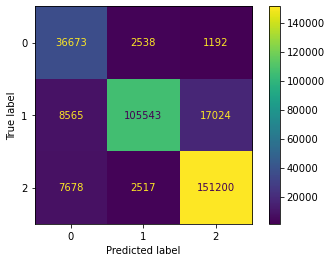

In [52]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [53]:
grid.best_params_

{'clf__C': 1,
 'clf__class_weight': {0: 2.7586755062369184,
  1: 0.8444238747005847,
  2: 0.6881044081160154},
 'clf__l1_ratio': 0.1,
 'clf__max_iter': 5000,
 'clf__multi_class': 'ovr',
 'clf__n_jobs': -1,
 'clf__penalty': 'l1',
 'clf__random_state': 42,
 'clf__solver': 'saga',
 'clf__warm_start': 'True'}

In [54]:
joblib.dump(grid, 'logistic_regression.pkl')

['logistic_regression.pkl']

In [55]:
joblib.dump(grid.best_params_, 'logistic_regression_best_params.pkl')

['logistic_regression_best_params.pkl']

In [56]:
logistic_regression_cv_results = pd.DataFrame(grid.cv_results_)

In [57]:
joblib.dump(logistic_regression_cv_results, 'logistic_regression_cv_results.pkl')

['logistic_regression_cv_results.pkl']

## Random Forest Classifier

We will do our hyperparameter search based off the best params that we obtained previously from Part 4.

In [58]:
def _compute_class_weight_dictionary(df):
    # helper for returning a dictionary instead of an array
    classes = np.unique(df['loan_status'])
    class_weight = compute_class_weight("balanced", np.unique(df['loan_status']), np.array(df['loan_status']))
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

In [59]:
weights = _compute_class_weight_dictionary(df)

C:\Users\kaile_000\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [60]:
weights

{0: 2.7586755062369184, 1: 0.8444238747005847, 2: 0.6881044081160154}

In [67]:
model = RandomForestClassifier()

In [68]:
param_grid = {'clf__n_estimators': [300],
             'clf__max_depth': [15],
             'clf__max_features': [28],
             'clf__bootstrap': ['True'],
             'clf__criterion': ['gini'],
             'clf__n_jobs' : [-1],
             'clf__warm_start' : ['False'],
             'clf__class_weight' : [weights],
             'clf__random_state' : [42]}

In [69]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [70]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1)

In [71]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

1:14:43.800656


              precision    recall  f1-score   support

           0       0.77      0.89      0.83     40403
           1       0.97      0.83      0.89    131132
           2       0.91      0.98      0.94    161395

    accuracy                           0.91    332930
   macro avg       0.88      0.90      0.89    332930
weighted avg       0.91      0.91      0.91    332930



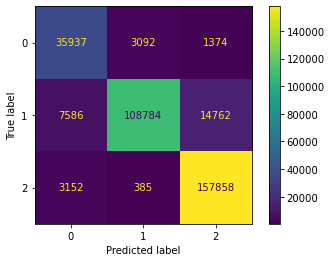

In [72]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [73]:
joblib.dump(grid, 'random_forest.pkl')

['random_forest.pkl']

In [40]:
preds = grid.predict(X_val)
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
f1 = ['random_forest']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

In [43]:
joblib.dump(grid, 'random_forest.pkl')
model_cv_results = pd.DataFrame(grid.cv_results_)
joblib.dump(model_cv_results, 'random_forest_cv_results.pkl')
joblib.dump(grid.best_params_, 'random_forest_best_params.pkl')

['random_forest_best_params.pkl']

## AdaBoost with strongest feature predictor

We will use the same best params that we obtained previously from Part 4.

In [74]:
model = AdaBoostClassifier()

In [75]:
param_grid = {'clf__n_estimators': [30000],
             'clf__learning_rate' : [1],
             'clf__random_state' : [42]}

In [76]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [77]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1)

In [78]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

6 days, 2:51:05.262598


              precision    recall  f1-score   support

           0       0.43      0.89      0.58     40403
           1       0.88      0.58      0.69    131132
           2       0.93      0.94      0.93    161395

    accuracy                           0.79    332930
   macro avg       0.75      0.80      0.74    332930
weighted avg       0.85      0.79      0.80    332930



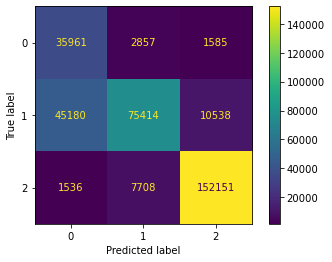

In [79]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [80]:
joblib.dump(grid, 'adaboost.pkl')

['adaboost.pkl']

### Other models are currently calculating on an older PC and the results will be appended as they are completed